In [8]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

<Axes: xlabel='cx', ylabel='cy'>

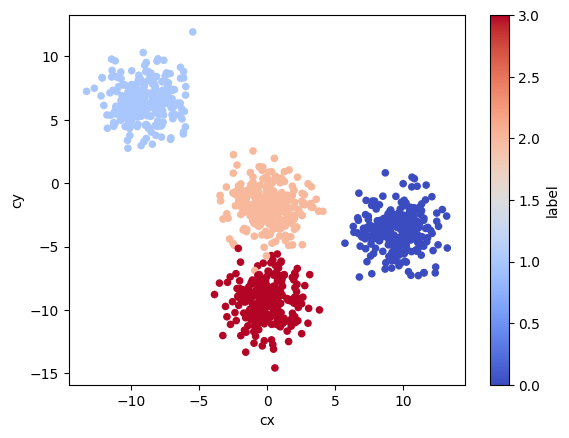

In [22]:
NUM_CLASSES = 4
NUM_FEATURES = 2

# Get data
X, y = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
)

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df = pd.DataFrame({"cx": X[:, 0], "cy": X[:, 1], "label": y})
df.plot(kind="scatter", x="cx", y="cy", c="label", cmap="coolwarm")

In [36]:
class BlobModelClassificator(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8,  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [37]:
model = BlobModelClassificator(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,    
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct / len(y_true)) * 100


In [38]:
y_logits = model(X_test)

# Softmax calculation on logits to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

tensor([[0.2575, 0.4347, 0.1462, 0.1616],
        [0.2268, 0.3506, 0.1474, 0.2752],
        [0.2346, 0.4520, 0.1580, 0.1554],
        [0.2230, 0.3997, 0.1525, 0.2248],
        [0.3047, 0.4192, 0.1018, 0.1742]], grad_fn=<SliceBackward0>)


In [43]:
epochs = 501
for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, axis=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test)
        y_pred = torch.softmax(y_logits, axis=1).argmax(dim=1)
        
        loss = loss_fn(y_logits, y_test)
        acc = accuracy_fn(y_pred, y_test)
        
        if epoch % (epochs // 10) == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Loss: {loss:.5f}")
        
    

Epoch: 0 | Loss: 0.01713, Acc: 99.50% | Loss: 0.01713
Epoch: 50 | Loss: 0.01623, Acc: 99.50% | Loss: 0.01623
Epoch: 100 | Loss: 0.01552, Acc: 99.50% | Loss: 0.01552
Epoch: 150 | Loss: 0.01492, Acc: 99.50% | Loss: 0.01492
Epoch: 200 | Loss: 0.01443, Acc: 99.50% | Loss: 0.01443
Epoch: 250 | Loss: 0.01402, Acc: 99.50% | Loss: 0.01402
Epoch: 300 | Loss: 0.01367, Acc: 99.50% | Loss: 0.01367
Epoch: 350 | Loss: 0.01340, Acc: 99.50% | Loss: 0.01340
Epoch: 400 | Loss: 0.01316, Acc: 99.50% | Loss: 0.01316
Epoch: 450 | Loss: 0.01295, Acc: 99.50% | Loss: 0.01295
Epoch: 500 | Loss: 0.01276, Acc: 99.50% | Loss: 0.01276


helper_functions.py already exists, skipping download


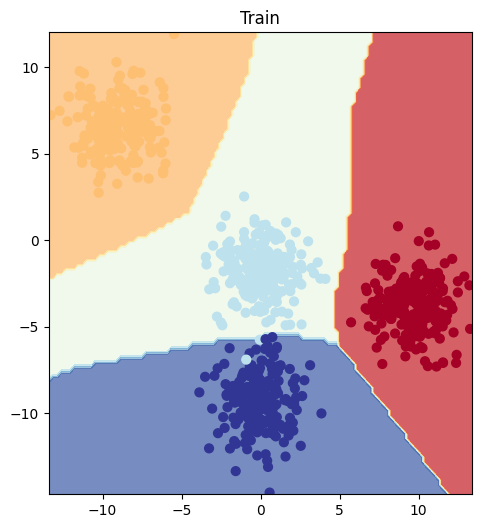

In [44]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)